In [51]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import numpy as np

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])
training_data, test_data = torch.utils.data.random_split(training_data, [40000, 10000])
train_dataloader = DataLoader(training_data, batch_size=64)
validation_dataloader = DataLoader(validation_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)


Using cpu device


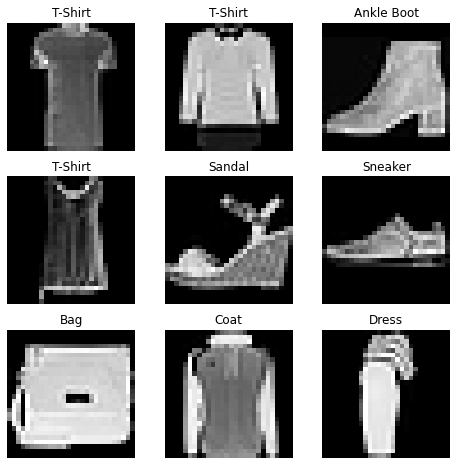

In [52]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [53]:
class NeuralNetwork(nn.Module):
    def __init__(self,n_neurons=512,input_dim=28*28,output_dim=10):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, n_neurons),
            nn.ReLU(),
            #nn.Mish(),
            #nn.SELU(),
            #nn.ELU(),
            nn.Linear(n_neurons, n_neurons),
            nn.ReLU(),
            #nn.Mish(),
            #nn.SELU(),
            #nn.ELU(),
            nn.Linear(n_neurons, output_dim),
            
        )
        #self.softmax=nn.Softmax()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        #output=self.softmax(x)  Softmax is not needed only because pytorch does this with cross entropy loss automatically
        return x

model = NeuralNetwork(n_neurons=512)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [54]:
learning_rate = 1e-3
batch_size = 64
epochs = 50
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [55]:
def fit_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss}  [{current}/{size}]")

def predict_dataset(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Error: \n Accuracy: {(100*correct)}%, Avg loss: {test_loss} \n")
    return test_loss, 100*correct
def predict(data,model,apply_softmax=True):
    labels=data[1]
    label=labels[0] #Take first element of batch
    data=data[0]  
    data=data[0,:,:,:] #Take first element of batch
    print(f"Size of one sample is {data.size()}") #First dimension is 1 because image is black & white. Would be 3 for RGB.
    pred = model(data)
    if apply_softmax:
        softmax=nn.Softmax()
        pred=softmax(pred)
    pred=pred.detach().numpy()
    pred=pred[0]
    print(f"Predicted label probabilities for first image: {pred*100}")
    print(f"True label for first image is {label.numpy()}")

In [6]:
less_loss = 10
count = 0
patience = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    fit_one_epoch(train_dataloader, model, loss_fn, optimizer)
    print('Validation results:')
    act_loss, act_accuracy = predict_dataset(validation_dataloader, model, loss_fn)
    if (act_loss < less_loss) and (less_loss - act_loss) > 0.009:
      less_loss = act_loss
    else:
      count += 1
    if count > patience:
      print('Count > patience')
      break
      
print('Test results:')
predict(next(iter(test_dataloader)),model,loss_fn)
predict_dataset(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 2.305665969848633  [0/40000]
loss: 2.2975120544433594  [6400/40000]
loss: 2.267486810684204  [12800/40000]
loss: 2.281987190246582  [19200/40000]
loss: 2.2667770385742188  [25600/40000]
loss: 2.2347750663757324  [32000/40000]
loss: 2.235502243041992  [38400/40000]
Validation results:
Error: 
 Accuracy: 51.32%, Avg loss: 2.228563044481217 

Epoch 2
-------------------------------
loss: 2.2379472255706787  [0/40000]
loss: 2.21960711479187  [6400/40000]
loss: 2.18316912651062  [12800/40000]
loss: 2.20697283744812  [19200/40000]
loss: 2.189913511276245  [25600/40000]
loss: 2.127819299697876  [32000/40000]
loss: 2.141845226287842  [38400/40000]
Validation results:
Error: 
 Accuracy: 54.14%, Avg loss: 2.1256977327310356 

Epoch 3
-------------------------------
loss: 2.1456472873687744  [0/40000]
loss: 2.108116626739502  [6400/40000]
loss: 2.0484237670898438  [12800/40000]
loss: 2.0901167392730713  [19200/40000]
loss: 2.059725046157837  [25600/40

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Error: 
 Accuracy: 79.78%, Avg loss: 0.6004831390396045 



0.6004831390396045

1. ELU: Achieved a little bit better accuracy under less epoch than ReLU.
  * On test set: 79.07% under 27 epoch

2. Mish: Did not achieve better accuracy, but with optimized learning rates it might could.
  * On test set: 78.63% under 32 epoch

3. SELU: Improved accuracy under significantly less epoch compared to ReLU.
  * On test set: 81.55% under 22 epoch

* Reference: ReLU achieved 78.84% under 30 epoch.

In [57]:
n_neurons = [i for i in range(100,1300,120)]
acc_neurons = []
for neuron in n_neurons:
  model = NeuralNetwork(n_neurons=neuron)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  less_loss = 10
  count = 0
  patience = 2
  acc = 0
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      fit_one_epoch(train_dataloader, model, loss_fn, optimizer)
      print('Validation results:')
      act_loss, act_accuracy = predict_dataset(validation_dataloader, model, loss_fn)
      if (act_loss < less_loss) and (less_loss - act_loss) >= 0.01:
        less_loss = act_loss
      else:
        count += 1
      acc = act_accuracy
      if count > patience:
        print(f"Early stopping at epoch {t}")
        break
  acc_neurons.append(acc);


  print('Test results:')
  predict(next(iter(test_dataloader)),model,loss_fn)
  predict_dataset(test_dataloader, model, loss_fn)

best_acc = 0
best_ind = 0
for i in range(0,len(acc_neurons)):
  if acc_neurons[i] > best_acc:
    best_acc = acc_neurons[i]
    best_ind = i
print(f"Best accuracy: {best_acc} with neurons: {n_neurons[best_ind]}")

Epoch 1
-------------------------------
loss: 2.3068463802337646  [0/40000]
loss: 2.2921009063720703  [6400/40000]
loss: 2.293015480041504  [12800/40000]
loss: 2.2955634593963623  [19200/40000]
loss: 2.2847249507904053  [25600/40000]
loss: 2.2673604488372803  [32000/40000]
loss: 2.26267147064209  [38400/40000]
Validation results:
Error: 
 Accuracy: 11.76%, Avg loss: 2.2579272689333387 

Epoch 2
-------------------------------
loss: 2.2589452266693115  [0/40000]
loss: 2.240696668624878  [6400/40000]
loss: 2.2372546195983887  [12800/40000]
loss: 2.2258787155151367  [19200/40000]
loss: 2.220154047012329  [25600/40000]
loss: 2.1985325813293457  [32000/40000]
loss: 2.2011682987213135  [38400/40000]
Validation results:
Error: 
 Accuracy: 34.48%, Avg loss: 2.18080341740019 

Epoch 3
-------------------------------
loss: 2.1867835521698  [0/40000]
loss: 2.160956382751465  [6400/40000]
loss: 2.1475393772125244  [12800/40000]
loss: 2.115069627761841  [19200/40000]
loss: 2.1153929233551025  [2560

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Error: 
 Accuracy: 78.43%, Avg loss: 0.6263112129679151 

Epoch 1
-------------------------------
loss: 2.312495470046997  [0/40000]
loss: 2.2926559448242188  [6400/40000]
loss: 2.278881072998047  [12800/40000]
loss: 2.2613437175750732  [19200/40000]
loss: 2.24570631980896  [25600/40000]
loss: 2.233516216278076  [32000/40000]
loss: 2.241340160369873  [38400/40000]
Validation results:
Error: 
 Accuracy: 21.44%, Avg loss: 2.2271734483682426 

Epoch 2
-------------------------------
loss: 2.232130527496338  [0/40000]
loss: 2.2123830318450928  [6400/40000]
loss: 2.1889219284057617  [12800/40000]
loss: 2.164789915084839  [19200/40000]
loss: 2.1526007652282715  [25600/40000]
loss: 2.135629177093506  [32000/40000]
loss: 2.1450929641723633  [38400/40000]
Validation results:
Error: 
 Accuracy: 48.84%, Avg loss: 2.1230114144124803 

Epoch 3
-------------------------------
loss: 2.123704195022583  [0/40000]
loss: 2.10304856300354  [6400/40000]
loss: 2.059638500213623  [12800/40000]
loss: 2.027007

Best neuron number: 1180 with accuracy: 80.4%

In [58]:
n_neurons[best_ind]

1180